In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import os
#PROJECT_ROOT = '/content/drive/My Drive/tfm/codigo' #@param {type:"string"}
#os.chdir(PROJECT_ROOT)
#print("Current working directory:", os.getcwd())

Current working directory: /content/drive/My Drive/tfm/codigo


In [ ]:
#!pip install python-dotenv
#import os
#from dotenv import load_dotenv

# Librerías

In [87]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Base de Datos y Variables de Entorno
from conexion import connect_to_postgresql, train_model, calculate_percentage_deviation, plot_predictions

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

# Machine Learning y estadística
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Red neuronal
import torch
import torch.nn as nn
import torch.optim as optim
import shap

# Exportación modelos
import joblib

In [88]:
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.2f}'.format

# Datos

In [89]:
engine = connect_to_postgresql()
conn = engine.raw_connection()
cur = conn.cursor()
try:
    query = """
    SELECT * FROM public.ft_indicadores;
    """
    cur.execute(query)

    df_ml = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

    conn.commit()
    print("La consulta se ha ejecutado con éxito")
except Exception as e:
    print(f"Ha ocurrido un error: {str(e)}")
finally:
    cur.close()
    conn.close()

df_ml.head()

Conexión establecida
La consulta se ha ejecutado con éxito


,Fecha,Habitaciones,Aseos,Precio,Metros,CUDIS,Provincia,Población,Renta bruta media por persona,Comodidades,Capital,Municipio_Tipo,Precio_medio_mun_tipo
0,2021-12-31,2.00,1.00,"56,000.00",66.00,"2,408,909.00",León,"120,082.00","35,956.00",0,True,León_Apartment,"131,994.02"
1,2021-12-31,3.00,2.00,"89,000.00",105.00,"2,408,907.00",León,"120,082.00","35,956.00",1,True,León_Apartment,"131,994.02"
2,2021-12-31,1.00,1.00,"55,000.00",45.00,"2,408,903.00",León,"120,082.00","35,956.00",0,True,León_Apartment,"131,994.02"
3,2021-12-31,3.00,1.00,"80,000.00",87.00,"2,408,906.00",León,"120,082.00","35,956.00",2,True,León_Apartment,"131,994.02"
4,2021-12-31,2.00,1.00,"56,000.00",66.00,"2,408,909.00",León,"120,082.00","35,956.00",1,True,León_Apartment,"131,994.02"


In [90]:
#df_ml['Periodo'] = df_ml['Fecha'].dt.year

In [91]:
df = df_ml.drop(['Fecha', 'Provincia', 'Municipio_Tipo'], axis = 1).copy()
df.head()

,Habitaciones,Aseos,Precio,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Capital,Precio_medio_mun_tipo
0,2.00,1.00,"56,000.00",66.00,"2,408,909.00","120,082.00","35,956.00",0,True,"131,994.02"
1,3.00,2.00,"89,000.00",105.00,"2,408,907.00","120,082.00","35,956.00",1,True,"131,994.02"
2,1.00,1.00,"55,000.00",45.00,"2,408,903.00","120,082.00","35,956.00",0,True,"131,994.02"
3,3.00,1.00,"80,000.00",87.00,"2,408,906.00","120,082.00","35,956.00",2,True,"131,994.02"
4,2.00,1.00,"56,000.00",66.00,"2,408,909.00","120,082.00","35,956.00",1,True,"131,994.02"


In [92]:
obs_X = df.drop(columns=['Precio'])
obs_X['Precio_medio_mun_tipo'] = np.log(obs_X['Precio_medio_mun_tipo'])
obj_Y = np.log(df[['Precio']])

In [93]:
obj_Y.head()

,Precio
0,10.93
1,11.40
2,10.92
3,11.29
4,10.93


In [94]:
# One-hot encoding de las variables categóricas
categorical_columns = list(obs_X.select_dtypes(['object']).columns)
obs_X_encoded  = pd.get_dummies(
    obs_X,
    columns=categorical_columns,
    drop_first=True
)
obs_X_encoded.head()

,Habitaciones,Aseos,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Capital,Precio_medio_mun_tipo
0,2.00,1.00,66.00,"2,408,909.00","120,082.00","35,956.00",0,True,11.79
1,3.00,2.00,105.00,"2,408,907.00","120,082.00","35,956.00",1,True,11.79
2,1.00,1.00,45.00,"2,408,903.00","120,082.00","35,956.00",0,True,11.79
3,3.00,1.00,87.00,"2,408,906.00","120,082.00","35,956.00",2,True,11.79
4,2.00,1.00,66.00,"2,408,909.00","120,082.00","35,956.00",1,True,11.79


In [95]:
# Normalizar las columnas numéricas
numeric_columns = list(obs_X.select_dtypes(['number']).columns)
numeric_vars = obs_X_encoded[numeric_columns]
scaler_x = StandardScaler()
numeric_vars_scaled = scaler_x.fit_transform(numeric_vars)
obs_X_encoded[numeric_columns] = numeric_vars_scaled

In [96]:
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(obj_Y)
obj_Y_scaled = pd.DataFrame(y_scaled, columns=['Precio'])

In [97]:
obj_Y_scaled.head()

,Precio
0,-1.06
1,-0.20
2,-1.10
3,-0.40
4,-1.06


In [98]:
# Convertir solo las columnas categóricas (True/False) a 0/1
categorical_columns_encoded = list(set(obs_X_encoded.columns) - set(numeric_columns))
obs_X_encoded[categorical_columns_encoded] = obs_X_encoded[categorical_columns_encoded].astype(int)

obs_X_encoded.head()

,Habitaciones,Aseos,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Capital,Precio_medio_mun_tipo
0,-0.92,-0.89,-0.91,-0.45,0.51,1.04,-0.77,1,0.55
1,0.24,0.88,0.36,-0.45,0.51,1.04,0.90,1,0.55
2,-2.09,-0.89,-1.60,-0.45,0.51,1.04,-0.77,1,0.55
3,0.24,-0.89,-0.22,-0.45,0.51,1.04,2.58,1,0.55
4,-0.92,-0.89,-0.91,-0.45,0.51,1.04,0.90,1,0.55


In [99]:
y = obj_Y_scaled['Precio'].copy()
X = obs_X_encoded.copy()

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (11738, 9)
Dimensiones de X_val: (5031, 9)
Dimensiones de y_train: (11738,)
Dimensiones de y_val: (5031,)


# MLP - Multiplayer Perceptron

| Modelo                 | Descripción                                         | ¿Recomendado para este caso?                          |
|------------------------|-----------------------------------------------------|------------------------------------------------------|
| MLP / ANN              | Capas densas, ideal para datos tabulares            | ✅ Sí, buena opción                                   |
| CNN                    | Usado más en imágenes, no aplicaría aquí            | ❌ No                                                 |
| RNN / LSTM             | Para series temporales (por ejemplo, precios en el tiempo) | ⚠️ Solo si tenés secuencias temporales por vivienda |
| TabNet, FT-Transformer | Redes más modernas para datos tabulares             | 🚀 Muy potentes, pero más complejas                  |


In [115]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.hidden2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.hidden3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.bn1(self.hidden1(x)))
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.bn2(self.hidden2(x)))
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.bn3(self.hidden3(x)))
        x = self.output(x)
        return x



In [116]:
# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

In [117]:
# Determina el tamaño de las características de entrada
input_size = X_train.shape[1]  # Número de columnas en el dataset
model = MLP(input_size)

print(f'Número de parámetros del modelo: {sum(p.numel() for p in model.parameters())}')

Número de parámetros del modelo: 12097


In [118]:
# Configurar la función de pérdida y optimizador
loss_fn = nn.MSELoss()  # MSE para un problema de regresión
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Optimizador Adam

In [119]:
# Hiperparámetros
n_epochs = 100
batch_size = 8
patience = 5

In [120]:
# Entrenar el modelo
best_val_loss, train_loss_hist, val_loss_hist, val_mae_hist, val_deviation_hist = train_model(
    model=model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=n_epochs,
    batch_size=batch_size,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scaler=scaler_y,
    patience=patience
)


Epoch 5/100 | Train Loss: 0.4751 | Val Loss: 0.3812 | Val MAE: 27,978.75
Epoch 10/100 | Train Loss: 0.4426 | Val Loss: 0.3718 | Val MAE: 27,026.45
Epoch 15/100 | Train Loss: 0.4152 | Val Loss: 0.3662 | Val MAE: 26,877.57
Epoch 20/100 | Train Loss: 0.4032 | Val Loss: 0.3651 | Val MAE: 26,777.90
⏹️ Early stopping activado en la época 20. Mejor Val Loss: 0.3630


In [121]:
# Evaluación final
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val_tensor)
    mse = loss_fn(y_pred_val, y_val_tensor)
    print(f"Mean Squared Error en Validación: {mse.item():.4f}")


Mean Squared Error en Validación: 0.3630


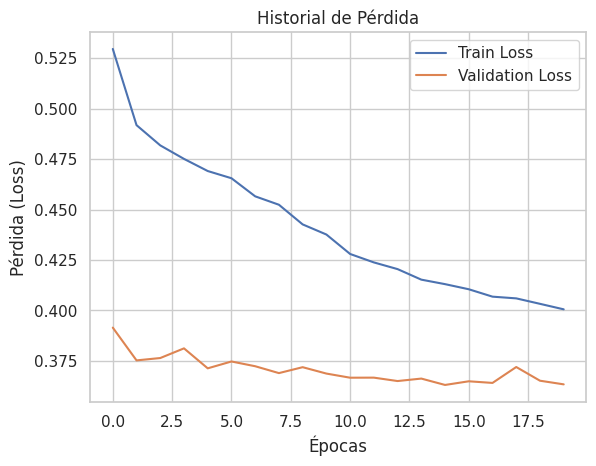

In [122]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.title('Historial de Pérdida')
plt.show()

In [123]:
# Configuración de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas para almacenar métricas por pliegue
mse_scores = []
mae_scores = []
r2_scores = []

# Validación cruzada en múltiples pliegues
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
    print(f'\n Fold {fold + 1}')

    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    model = MLP(input_size=X_train_tensor.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()

    print("Entrenando modelo...")

    _, train_loss_hist, val_loss_hist, val_mae_hist, val_deviation_hist = train_model(
        model,
        X_train_fold,
        y_train_fold,
        X_val_fold,
        y_val_fold,
        n_epochs=n_epochs,
        batch_size=batch_size,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scaler=scaler_y,
        patience=patience
    )

    print("Entrenamiento terminado. Evaluando...")

    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_fold).cpu().numpy().reshape(-1, 1)
        y_val_fold_np = y_val_fold.cpu().numpy().reshape(-1, 1)

        # Invertir escalado
        y_pred_inv = scaler_y.inverse_transform(y_pred_val).ravel()
        y_val_inv = scaler_y.inverse_transform(y_val_fold_np).ravel()

        # Invertir log
        y_pred_final = np.exp(y_pred_inv)
        y_val_final = np.exp(y_val_inv)

    # Métricas en la escala original (€)
    mse = mean_squared_error(y_val_final, y_pred_final)
    mae = mean_absolute_error(y_val_final, y_pred_final)
    r2 = r2_score(y_val_final, y_pred_final)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f'Fold {fold + 1}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}')

# Resultados finales
print(f'\nResultados promedio tras {kf.get_n_splits()} pliegues:')
print(f'MSE promedio: {np.mean(mse_scores):.4f}')
print(f'MAE promedio: {np.mean(mae_scores):.4f}')
print(f'R² promedio: {np.mean(r2_scores):.4f}')



 Fold 1
Entrenando modelo...
Epoch 5/100 | Train Loss: 0.4734 | Val Loss: 0.3726 | Val MAE: 27,687.16
Epoch 10/100 | Train Loss: 0.4481 | Val Loss: 0.3660 | Val MAE: 27,349.50
Epoch 15/100 | Train Loss: 0.4213 | Val Loss: 0.3640 | Val MAE: 27,114.28
Epoch 20/100 | Train Loss: 0.4009 | Val Loss: 0.3643 | Val MAE: 26,918.98
⏹️ Early stopping activado en la época 22. Mejor Val Loss: 0.3607
Entrenamiento terminado. Evaluando...
Fold 1: MSE=1314205312.00, MAE=26982.15, R²=0.5646

 Fold 2
Entrenando modelo...
Epoch 5/100 | Train Loss: 0.4726 | Val Loss: 0.4182 | Val MAE: 28,979.86
⏹️ Early stopping activado en la época 6. Mejor Val Loss: 0.4100
Entrenamiento terminado. Evaluando...
Fold 2: MSE=1498880384.00, MAE=28711.51, R²=0.5553

 Fold 3
Entrenando modelo...
Epoch 5/100 | Train Loss: 0.4931 | Val Loss: 0.3392 | Val MAE: 26,116.99
Epoch 10/100 | Train Loss: 0.4689 | Val Loss: 0.3340 | Val MAE: 25,800.99
Epoch 15/100 | Train Loss: 0.4432 | Val Loss: 0.3277 | Val MAE: 25,288.63
⏹️ Early sto

# Análisis de la fase de entrenamiento

In [124]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

In [125]:
best_val_loss, train_loss_hist, val_loss_hist, val_mae_hist, val_deviation_hist = train_model(
    model,
    X_train_sub,
    y_train_sub,
    X_val_sub,
    y_val_sub,
    n_epochs,
    batch_size,
    loss_fn,
    optimizer,
    scaler_y,
  )

Epoch 5/100 | Train Loss: 0.4548 | Val Loss: 0.3959 | Val MAE: 28,546.95
Epoch 10/100 | Train Loss: 0.4289 | Val Loss: 0.3862 | Val MAE: 27,936.47
Epoch 15/100 | Train Loss: 0.4097 | Val Loss: 0.3905 | Val MAE: 27,828.28
⏹️ Early stopping activado en la época 18. Mejor Val Loss: 0.3828


In [126]:
print(f"Mejor pérdida de validación (MSE): {best_val_loss:.4f}")

Mejor pérdida de validación (MSE): 0.3828


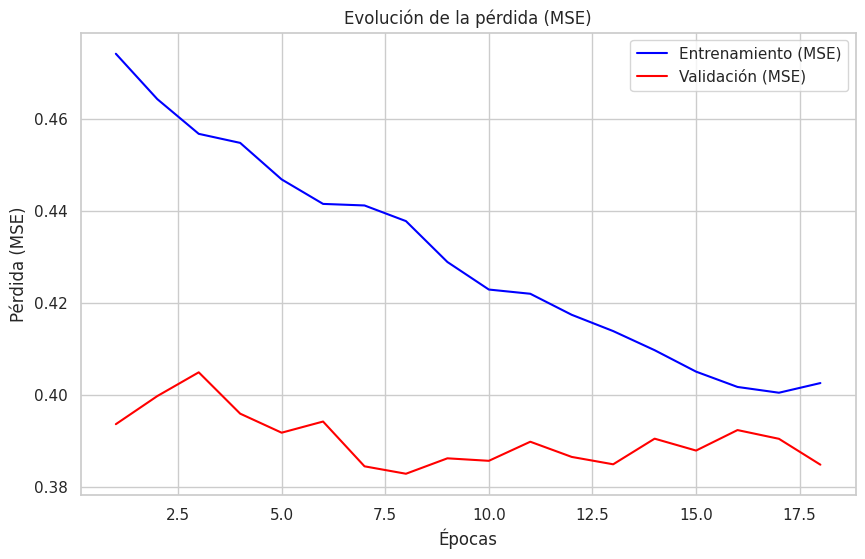

In [127]:
# Número de épocas
num_epochs = len(train_loss_hist)

# Gráfico de pérdida (MSE)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_hist, label='Entrenamiento (MSE)', color='blue')
plt.plot(range(1, num_epochs + 1), val_loss_hist, label='Validación (MSE)', color='red')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

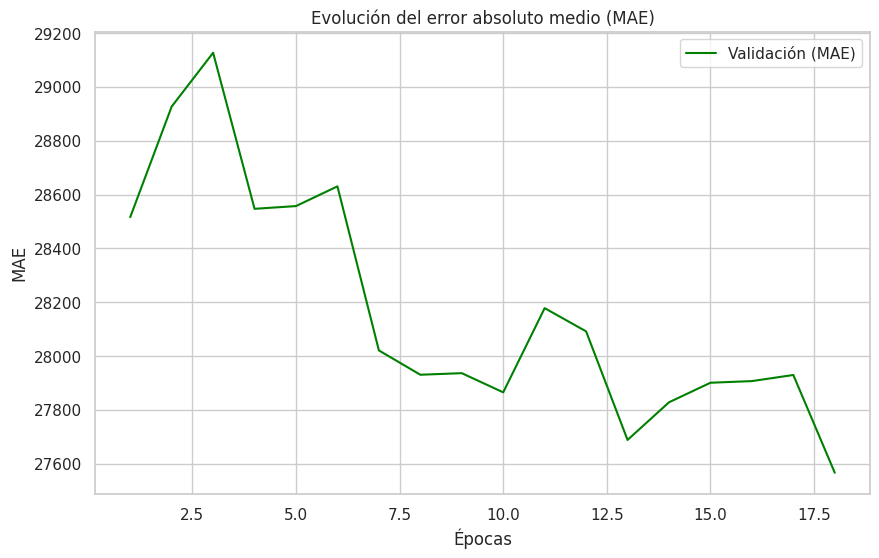

In [128]:
# Obtener el número de épocas
num_epochs = len(train_loss_hist)  # Debe coincidir con el historial registrado

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_mae_hist, label='Validación (MAE)', color='green')
plt.title('Evolución del error absoluto medio (MAE)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Análisis de la fase de test

Pérdida en el conjunto de prueba (MSE): 0.3820
Error absoluto medio en el conjunto de prueba (MAE): 0.4825


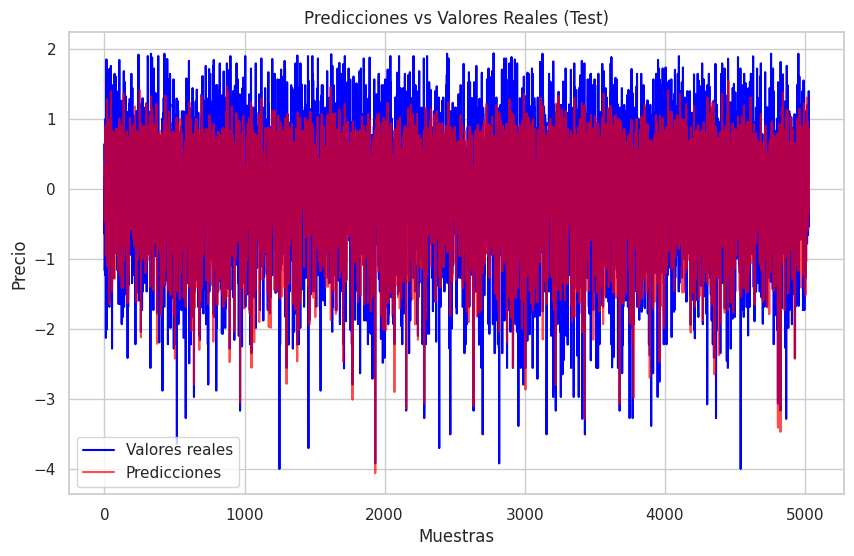

In [129]:
# Evaluación en el conjunto de prueba
model.eval()  # Modo evaluación
with torch.no_grad():
    y_test_pred = model(X_val_tensor)

# Calcular métricas
mse_test = torch.mean((y_test_pred - y_val_tensor) ** 2).item()  # MSE
mae_test = torch.mean(torch.abs(y_test_pred - y_val_tensor)).item()  # MAE

print(f"Pérdida en el conjunto de prueba (MSE): {mse_test:.4f}")
print(f"Error absoluto medio en el conjunto de prueba (MAE): {mae_test:.4f}")

# Gráfico comparativo: predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(y_val_tensor.cpu(), label='Valores reales', color='blue')
plt.plot(y_test_pred.cpu(), label='Predicciones', color='red', alpha=0.7)
plt.title('Predicciones vs Valores Reales (Test)')
plt.xlabel('Muestras')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()


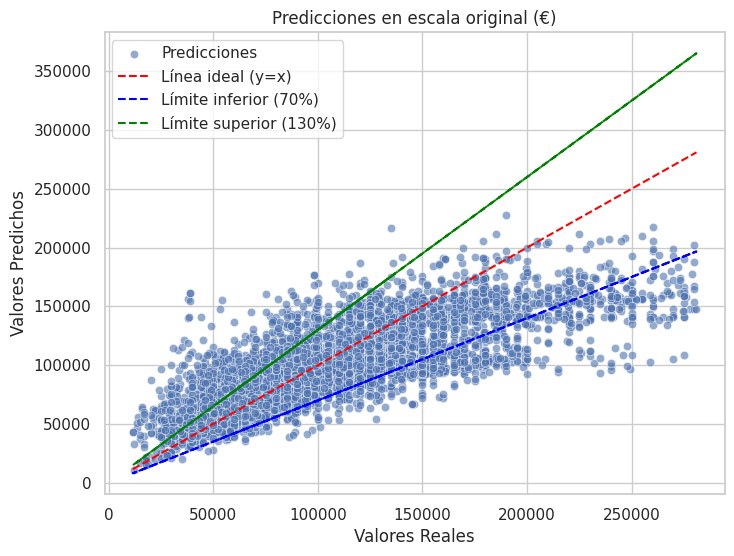

In [130]:
# Supón que ya tienes y_val_pred y y_val como tensores
y_val_pred = y_test_pred.cpu().numpy().reshape(-1, 1)
y_val_true = y_val.to_numpy().reshape(-1, 1)

# 1. Invertir el escalado con StandardScaler
y_val_pred_unscaled = scaler_y.inverse_transform(y_val_pred).ravel()
y_val_true_unscaled = scaler_y.inverse_transform(y_val_true).ravel()

# 2. Invertir el logaritmo para volver a euros
y_val_pred_original = np.exp(y_val_pred_unscaled)
y_val_true_original = np.exp(y_val_true_unscaled)

# 3. Graficar
plot_predictions(y_val_true_original, y_val_pred_original, title="Predicciones en escala original (€)")

# Shap Values

In [131]:
sample_size = 10000
X_train_sample = X_train_tensor[:sample_size]

In [132]:
explainer = shap.GradientExplainer(model, X_train_sample)
explainer.model_output = 'raw'

In [133]:
sample_test_size = 400
X_test_sample = X_train_tensor[:sample_test_size]

In [134]:
shap_values = explainer.shap_values(X_test_sample)
shap_values = shap_values[:,:,-1]

In [135]:
columns=X_train.columns
columns = columns.to_list()

In [136]:
shap_values_abs = np.abs(shap_values)
shap_df = pd.DataFrame(shap_values_abs, columns=X_train.columns)

In [137]:
shap_summary_df = pd.DataFrame({
    "Feature": [f"{columns[i]}" for i in range(len(columns))],
    "Mean Absolute SHAP Value": shap_df.mean(axis=0).values,
    "Std Deviation of SHAP Value": shap_df.std(axis=0).values
})

In [138]:
shap_summary_df.sort_values("Mean Absolute SHAP Value", ascending = False).head(25)

,Feature,Mean Absolute SHAP Value,Std Deviation of SHAP Value
8,Precio_medio_mun_tipo,0.38,0.34
1,Aseos,0.29,0.06
2,Metros,0.15,0.11
6,Comodidades,0.08,0.04
3,CUDIS,0.06,0.05
0,Habitaciones,0.05,0.05
5,Renta bruta media por persona,0.04,0.04
4,Población,0.04,0.03
7,Capital,0.03,0.03


In [139]:
x_test_sample = pd.DataFrame(X_test_sample, columns=X_val.columns)

<ipython-input-140-377e64841d8c>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test_sample)


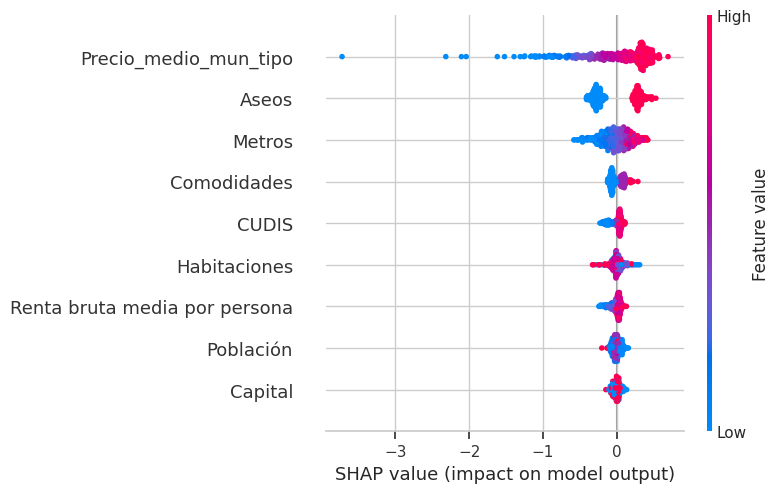

In [140]:
shap.summary_plot(shap_values, x_test_sample)


📌 **Estos SHAP values están en la escala del modelo**, es decir, el dominio de salida de la red neuronal (después de aplicar `np.log` y luego `StandardScaler`). No están directamente en euros, pero **nos dicen la importancia relativa de cada feature en la predicción**.

---

### 🔍 ¿Qué significa cada columna?

- **Mean Absolute SHAP Value**: Magnitud media del efecto que tiene cada variable sobre las predicciones (cuánto cambia el output del modelo al modificar esa variable).
- **Std Deviation**: Variabilidad de ese efecto entre diferentes observaciones (¿a veces tiene mucho efecto y a veces poco?).

---

### 📊 Interpretación de tus resultados

| Feature | SHAP Mean | SHAP Std | Interpretación |
|--------|-----------|----------|----------------|
| **Precio_medio_mun_tipo** | 0.38 | 0.31 | 🔝 Es la variable **más influyente** del modelo. Tiene un efecto fuerte y muy variable según el caso. El modelo depende mucho de ella para ajustar el precio. |
| **Aseos** | 0.32 | 0.06 | 🔧 Segunda en importancia, y su efecto es **muy estable**. Aumentar/variar el número de aseos casi siempre cambia el precio de forma similar. |
| **Metros** | 0.15 | 0.12 | 📏 Importante también, aunque menos que "Aseos", con algo más de variabilidad. A más metros, más precio, pero no de forma tan constante. |
| **Capital** | 0.06 | 0.03 | 🏙️ Ser o no capital tiene cierto peso. Aporta algo, pero no es determinante. |
| **Comodidades** | 0.06 | 0.03 | 🛋️ Variables como ascensor, garaje, terraza… suman, pero con un peso moderado. |
| **CUDIS** | 0.04 | 0.03 | 📌 Indicador de zona, también aporta algo pero con bajo impacto general. |
| **Habitaciones** | 0.04 | 0.04 | 🛏️ Curiosamente tiene un impacto bajo y algo más variable. Puede indicar que el modelo prefiere otras señales (como aseos o metros). |
| **Población** | 0.03 | 0.02 | 👥 Característica de contexto general del municipio, con poca influencia. |
| **Renta bruta media por persona** | 0.03 | 0.03 | 💶 Algo aporta en ciertas zonas, pero no destaca mucho frente a las variables de la vivienda en sí. |

---

### 💡 ¿Qué puedes hacer con esto?

- **Validar intuiciones**: Por ejemplo, que el "Precio medio del municipio por tipo de vivienda" es lo más determinante.
- **Simplificar tu modelo** si buscas algo más interpretable: puedes usar las 3–4 variables más relevantes.
- **Comunicar a no técnicos**: puedes decir que “el modelo ajusta el precio principalmente en función del mercado local y detalles como aseos y superficie”.

---


# Exportación del modelo

In [141]:
# Exportar el StandardScaler de la matriz de entrada (X)
joblib.dump(scaler_x, '/content/drive/My Drive/tfm/codigo/modelo_ann/standardscaler_datos_entrada.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ann/standardscaler_datos_entrada.pkl']

In [142]:
# Exportar el StandardScaler de la variable precio (y)
joblib.dump(scaler_y, '/content/drive/My Drive/tfm/codigo/modelo_ann/standardscaler_precio.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ann/standardscaler_precio.pkl']

In [143]:
# Modelo de ANN
joblib.dump(model, '/content/drive/My Drive/tfm/codigo/modelo_ann/modelo_ann.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ann/modelo_ann.pkl']